# Project 4: West Nile Virus Prediction
____________

# Part 1b - Spray Data EDA & Cleaning

### Group 4, SG-DSI-18

In this notebook, we will be cleaning and analyzing the spray data.

Spray dataset includes information on the spraying efforts carried out over the past years. We will be able to get information on the locations and time of spraying.

## Problem Statement

West Nile Virus (Wnv), a mosquito-bourne arbovirus, has been causing significant and sometimes severe human diseases. Although pesticides are known to be effective in dealing with the virus-carrying mosquitoes, it is expensive to deploy pesticides throughout the city. As data scientists in the Division of Societal Cures in Epidemiology & New Creative Engineering, we want to understand the factors driving the spread of Wnv by leveraging on data collected by Chicago's weather stations and the surveillance system set up by the Chicago Department of Public Health. We also want to develop a classfication model that could predict the presence of Wnv within the area of Windy City. Through these studies, we hope to suggest a cost-efficient and effective method of deploying pesticides within the area.

### Contents:
- [EDA & Cleaning](#EDA-&-Cleaning)

### Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import geopy.distance
from datetime import datetime, timedelta

# Imports for geospatial data visualizations
import folium
from folium.plugins import HeatMapWithTime
from branca.element import Figure

In [2]:
spray = pd.read_csv('../datasets/spray.csv')
# Use this to load previously saved .pkl file
infile = open('../datasets/train_final.pkl', 'rb')
train = pickle.load(infile)
infile.close()

## EDA & Cleaning

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
# Display top 5 rows
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [5]:
spray.describe()

,Latitude,Longitude
count,14835.000000,14835.000000
mean,41.904828,-87.736690
std,0.104381,0.067292
min,41.713925,-88.096468
25%,41.785001,-87.794225
50%,41.940075,-87.727853
75%,41.980978,-87.694108
max,42.395983,-87.586727


In [6]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [7]:
spray.shape

(14835, 4)

### Missing Values

We observed that there are some missing 'Time' values.

In [8]:
train.head()

,Date,Week,Year,Trap,Latitude,Longitude,WnvPresent,Species,species_no,NumMosquitos,Station
0,2007-05-29,22,2007,T002,41.954690,-87.800991,0,CULEX PIPIENS/RESTUANS,2.0,1,1
1,2007-05-29,22,2007,T002,41.954690,-87.800991,0,CULEX RESTUANS,1.0,1,1
2,2007-05-29,22,2007,T007,41.994991,-87.769279,0,CULEX RESTUANS,1.0,1,1
3,2007-05-29,22,2007,T015,41.974089,-87.824812,0,CULEX PIPIENS/RESTUANS,2.0,1,1
4,2007-05-29,22,2007,T015,41.974089,-87.824812,0,CULEX RESTUANS,1.0,4,1


In [9]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

We decide to drop the 'Time' columns and only make use of the spray locations at each date.

In [10]:
# Dropping the Time columns
spray = spray.drop(columns=['Time'])

### Duplicates

We want to drop duplicates.

In [11]:
spray.drop_duplicates(inplace=True)

In [12]:
# After dropping
spray.shape

(14294, 3)

### Visualizing Spray Data

Below, we will study the data for spray and train. We will be looking at the impact of the spray on the mosquitoes and the West Nile Virus.

In [13]:
spray['Date'].unique()

array(['2011-08-29', '2011-09-07', '2013-07-17', '2013-07-25',
       '2013-08-08', '2013-08-15', '2013-08-16', '2013-08-22',
       '2013-08-29', '2013-09-05'], dtype=object)

In [14]:
#Create datetime type for Date
spray['Date_1'] = pd.to_datetime(spray['Date'])

In [15]:
# Get spray dates
spray_dates = spray['Date_1'].unique()
spray_2011 = spray_dates[:2]
spray_2013 = spray_dates[2:]

In [16]:
wnv_2011 = train[train['Date'].dt.year==2011].groupby('Date')['WnvPresent'].sum()
wnv_2013 = train[train['Date'].dt.year==2013].groupby('Date')['WnvPresent'].sum()
mosquitos_2011 = train[train['Date'].dt.year==2011].groupby('Date')['NumMosquitos'].sum()
mosquitos_2013 = train[train['Date'].dt.year==2013].groupby('Date')['NumMosquitos'].sum()

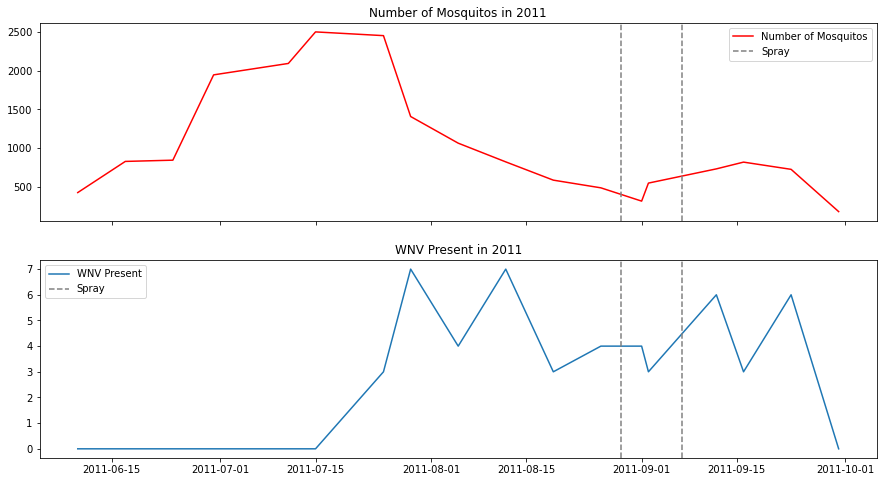

In [17]:
fig, axes = plt.subplots(nrows=2,sharex=True, figsize=(15,8))

axes[0].plot(mosquitos_2011.index,mosquitos_2011.values,color='red')
for spray_date in spray_2011:
    axes[0].axvline(x=spray_date, color='grey', ls='--')
axes[0].set_title('Number of Mosquitos in 2011')
axes[0].legend(['Number of Mosquitos','Spray']);

axes[1].plot(wnv_2011.index,wnv_2011.values)
for spray_date in spray_2011:
    axes[1].axvline(x=spray_date, color='grey', ls='--')
axes[1].set_title('WNV Present in 2011')
axes[1].legend(['WNV Present','Spray']);

We observed from above in the Year 2011, the trending of mosquito numbers does not seem too affected by the spraying efforts that were carried out.

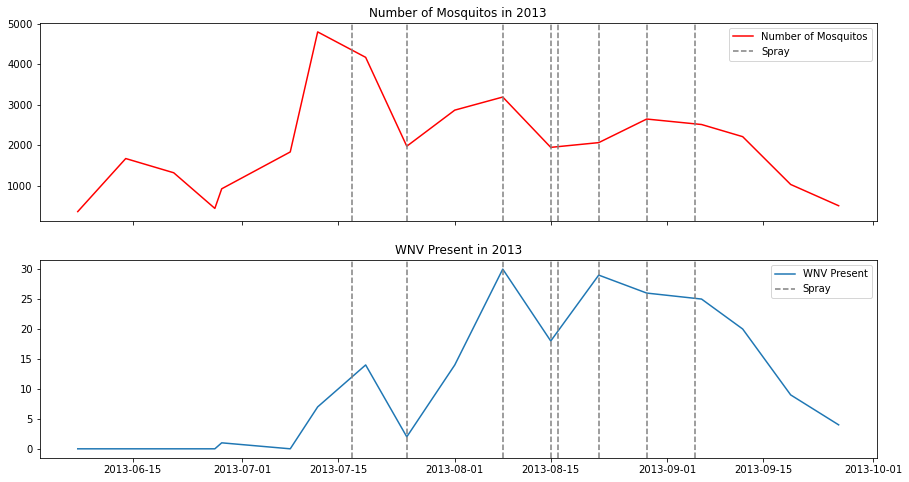

In [18]:
fig, axes = plt.subplots(nrows=2,sharex=True, figsize=(15,8))

axes[0].plot(mosquitos_2013.index,mosquitos_2013.values,color='red',label='Number of Mosquitos')
for spray_date in spray_2013:
    axes[0].axvline(x=spray_date, color='grey', ls='--')
axes[0].set_title('Number of Mosquitos in 2013');
axes[0].legend(['Number of Mosquitos','Spray'], loc=1);
# ax2.legend(loc=1)

axes[1].plot(wnv_2013.index,wnv_2013.values)
for spray_date in spray_2013:
    axes[1].axvline(x=spray_date, color='grey', ls='--')
axes[1].set_title('WNV Present in 2013');
axes[1].legend(['WNV Present','Spray']);

As we can see in the week of 15-Jul-2013, the number of mosquitos decreased after the first spray. However, the 2nd spray did not seem to reduce the mosquito population. Instead both mosquito population and WNV virus increased sharply after that.

Next, we will look at the coverage of the sprays made on each day. We can also see whether the spray covered the traps.

In [19]:
# Create latitude and longitude list for traps in train data
lat_long_train = []

for trap in train['Trap'].unique():
    lat = train.loc[train['Trap'] == trap, 'Latitude'].values[0]
    long = train.loc[train['Trap'] == trap, 'Longitude'].values[0]
    lat_long_train.append([trap, (lat, long)])

In [20]:
# Save .pkl for trap locations
trap_location = pd.DataFrame(lat_long_train, columns=['Trap', 'lat_long'])
pickle.dump(trap_location, open('../datasets/trap_location.pkl', 'wb'))

In [21]:
# for spray
# Create latitude and longitude list to pass into map
lat_long_spray = []
for date in spray['Date'].unique():
    temp = []
    for i, row in spray[spray['Date'] == date].iterrows():
        temp.append([row['Latitude'], row['Longitude']])
    lat_long_spray.append(temp)

In [22]:
# Create dataframe with total number of mosquitoes at each date and trap
group_mosq = train.groupby(['Date', 'Trap','WnvPresent'], as_index=False).sum()
group_mosq = group_mosq.loc[group_mosq['WnvPresent']==1]
group_mosq['Date_1'] = pd.to_datetime(group_mosq['Date'])

group_mosq = group_mosq.loc[group_mosq['Date_1'].dt.year >= 2013]
group_mosq.head()

,Date,Trap,WnvPresent,Week,Year,Latitude,Longitude,species_no,NumMosquitos,Station,Date_1
3870,2013-06-28,T094,1,25,2013,41.720848,-87.666014,2.0,38,2,2013-06-28
3958,2013-07-12,T008,1,54,4026,84.016628,-175.555842,3.0,78,2,2013-07-12
3985,2013-07-12,T073,1,27,2013,41.773215,-87.600880,1.0,9,2,2013-07-12
4009,2013-07-12,T158,1,27,2013,41.682587,-87.707973,1.0,36,2,2013-07-12
4011,2013-07-12,T159,1,27,2013,41.732984,-87.649642,2.0,27,2,2013-07-12


In [23]:
group_mosq.shape

(169, 11)

In [24]:
# for number of mosquitoes
# Create latitude and longitude list to pass into map
lat_long_mosq = []
for date in group_mosq['Date'].unique():
    temp = []
    for i, row in group_mosq[group_mosq['Date'] == date].iterrows():
        temp.append([row['Latitude'], row['Longitude'], row['NumMosquitos']])
    lat_long_mosq.append(temp)

In [25]:
# Plot the map for spraying efforts
# Blue dots indicate the trap locations
fig = Figure(width=850, height=550)
m = folium.Map(location=[41.9, -87.7], zoom_start=9, min_zoom=9, max_zoom=11, tiles='cartodbdark_matter')
fig.add_child(m)

gradient = {.33: 'blue', .66: 'green', 1: 'yellow'}
HeatMapWithTime(lat_long_spray, index=list(spray['Date'].unique()), radius=0.03, gradient=gradient, position='bottomright', name='spray_zones', scale_radius=True).add_to(m)

for item in lat_long_train:
    folium.CircleMarker(item[1], radius=1).add_to(m)


m

In [41]:
# Plot the map for number of mosquitoes
# Blue dots indicate the trap locations
fig = Figure(width=850, height=550)
m2 = folium.Map(location=[41.9, -87.7], zoom_start=9, min_zoom=9, max_zoom=11, tiles='cartodbdark_matter')
fig.add_child(m2)

gradient = {.33: 'blue', .66: 'yellow', 1: 'red'}
HeatMapWithTime(lat_long_mosq, index=list(np.datetime_as_string(group_mosq['Date'].unique(), unit='D')), gradient=gradient, radius=20, position='bottomright').add_to(m2)

for item in lat_long_train:
    folium.CircleMarker(item[1], radius=1).add_to(m2)

m2

From the map above, we can clearly see the coverage of the spray on each given date and which traps are nearby the spray zone.

In [42]:
# Saves Map to an HTML File
m.save('../images/spray_map.html') 
m2.save('../images/wnv_mosq.html') 

### Add indicator if nearby spray zone  

According to this [reference](https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/), mosquito sprays will last over a period of **30 days**. 

According to this [reference](https://www.montcopa.org/DocumentCenter/View/8932/FAQMosquitoSpraying?bidId=), mosquito sprays can travel up to **300 feet** for it to still be effective.

We want to include a column showing whether each trap was sprayed.

In [28]:
# Function to check if trap is nearby spray
# It will accept location in the format of (lat, long)
def check_near_spray(trap_loc, spray_loc):
    dist_tolerance = 300
    dist = geopy.distance.distance(trap_loc, spray_loc).feet
    return (dist <= dist_tolerance)

In [29]:
# Convert time value to datetime object
spray['Date'] = pd.to_datetime(spray['Date'], format='%Y-%m-%d')
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')

In [30]:
# Check data type
spray['Date'].dtypes

dtype('<M8[ns]')

In [31]:
train['Date'].dtypes

dtype('<M8[ns]')

In [32]:
# Create a dict for the 10 spray dates
# Each value will represent all the spray locations on that date
spray_dict = {}
for i, date in enumerate(spray['Date'].unique()):
    spray_dict[str(date).split('T')[0]] = lat_long_spray[i]

In [33]:
train['Trap'].unique()

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T027', 'T078', 'T097', 'T099', 'T100', 'T102',
      

In [34]:
train.loc[train['Trap'] == 'T002', ['Latitude', 'Longitude']].values[0]

array([ 41.95469 , -87.800991])

In [35]:
# Create a dict for all the trap locations
trap_locations = {}
for trap in train['Trap'].unique():
    trap_locations[trap] = tuple(train.loc[train['Trap'] == trap, ['Latitude', 'Longitude']].values[0])

In [36]:
trap_locations

{'T002': (41.95469, -87.800991),
 'T007': (41.994991, -87.769279),
 'T015': (41.974089, -87.824812),
 'T045': (41.9216, -87.666455),
 'T046': (41.891118, -87.65449100000001),
 'T048': (41.867108, -87.654224),
 'T049': (41.896282, -87.655232),
 'T050': (41.919343, -87.694259),
 'T054': (41.921965, -87.632085),
 'T086': (41.688324, -87.676709),
 'T091': (41.862292, -87.64886),
 'T094': (41.720848, -87.666014),
 'T096': (41.731922, -87.677512),
 'T129': (41.891126, -87.61156),
 'T143': (41.999128999999996, -87.795585),
 'T148': (42.01743, -87.68776899999999),
 'T153': (41.907645, -87.760886),
 'T159': (41.732984, -87.649642),
 'T009': (41.981964000000005, -87.812827),
 'T011': (41.944869, -87.832763),
 'T016': (42.011601, -87.81150600000001),
 'T019': (41.94983, -87.69845699999999),
 'T025': (41.979243, -87.750938),
 'T028': (41.986921, -87.689778),
 'T031': (41.801497999999995, -87.763416),
 'T033': (41.906638, -87.701431),
 'T089': (41.723195000000004, -87.64997),
 'T090': (41.868077, -

In [37]:
# Create a dict for all traps and spray date affecting it
trap_affected = {}
for trap_key, trap_value in trap_locations.items():
    dates = []
    for spray_key, spray_value in spray_dict.items():
        for spray_loc in spray_value:
            if check_near_spray(trap_value, spray_loc):
                dates.append(spray_key)
                break
    trap_affected[trap_key] = dates

In [38]:
# Create new column in train data
train['trap_sprayed'] = 0

# Specified 30 days which spray will still be in effect
numdays = 30

# Infill value indicating if the trap is within spray zone
for trap, affected_dates in trap_affected.items():
    if len(affected_dates) > 0:
        for date in affected_dates:
            end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=numdays)
            train.loc[(train['Date'].between(datetime.strptime(date, '%Y-%m-%d'), end_date)) & (train['Trap'] == trap), 'trap_sprayed'] = 1

### Save to `.pkl`

In [39]:
# Save cleaned dataset as a pickle file
outfile = open('../datasets/spray_final.pkl','wb')
pickle.dump(spray, outfile)
outfile.close()

In [40]:
# Save cleaned dataset as a pickle file
outfile = open('../datasets/train_spray_final.pkl','wb')
pickle.dump(train, outfile)
outfile.close()